In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext notexbook
%texify

In [2]:
from narsil2.mm.segmentation import load_net, segment_cells_dir, segment_all_positions, MMDataTest, segment_channels_dir
from narsil2.segmentation.transformations import OmniTestTransformations, UnetTestTransformations
from narsil2.mm.segmentation import cut_channels_all_positions, cut_fluor_all_positions, cut_fluor_one_position
from narsil2.mm.segmentation import cut_channels_one_position
from narsil2.fish.transformations import FishTransformations
from narsil2.mm.tracking import process_all_positions, process_one_position
import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

In [3]:
root_dir = '/mnt/sda2/Praneeth/ASTFISH/'

phase_main_dir = root_dir + 'data/EXP-21-BV6160 AST FISH 210525/The run'
analysis_dir = root_dir + 'analysis_rev/EXP-21-BV6160 AST FISH 210525/'
genotype_dir = root_dir + 'data/EXP-21-BV6160 AST FISH 210525/Genotype'
positions = list(range(101, 172)) + list(range(201, 272))
#positions = [101]

#### Model paths

In [4]:
cell_seg_path = '../../saved_models/omnipose_mm_old_new_320_long.ckpt'
channel_seg_path = '../../saved_models/channels.pth'
tracker_model_path = '../../saved_models/tracker_model.pth'

#### Segmentation 

In [5]:
segmentation_parameters = {
    'fileformat': "*.tiff",
    'seg_method': {
        'cells': 'omnipose',
        'channels': 'unet'
    },
    'cell_transforms': OmniTestTransformations(return_tensors=True, shrink_half=False),
    'channel_transforms': UnetTestTransformations(return_tensors=True,
                                                  shrink_half=False,
                                                  pad_to=16,
                                                  add_noise=True,
                                                  flip=False),
    'channel_add_noise': True,
    'clean_mask': False,
    'cell_prob_threshold': 0.3,
    'channel_seg_threshold': 0.7,
    'min_size': 400,
    'save_seg_mask': True,
    'save_channel_seg_mask': False,
    'save_seg_dir': None,
    'model_paths': {
        'cells': cell_seg_path,
        'channels': channel_seg_path
    },
    'segmentation_devices': {
        'cells': 'cuda:1', # cell net takes more space so you will have to run it on cuda:1
        'channels': 'cuda:0' # channel net is smaller so you can run it independently in a different process.
    },
    'channel_cutting_params': {
        'channel_min': 600,
        'channel_max': 1200,
        'channel_sum': 300,
        'hist_peaks_distance': 90,
        'minimum_barcode_distance': 160,
        'num_channels': 16,
        'first_barcode_index': 10,
    },
    'flip_positions': range(201, 272),
    'analysis_dir': analysis_dir,
    'write_dir_names': {
        'cell_seg_raw': 'segmented_phase',
        'channel_seg_raw': 'segmented_channels',
        'channel_stacks' : 'blobs',
        'fluor_stacks': 'fish_channels',
    },
    'dir_names': {
        'phase': 'phase'
    },
    'cutting_and_writing_params' : {
        'num_images': 33,
        'channel_width': 80,
        'cut_until_frames': 33,
        
    }
    
}

#### Uncomment and run the next cell to do segmentation

In [6]:
#segment_all_positions(phase_main_dir, segmentation_parameters, positions)

#### Fluorescence parameters

In [7]:
fluorescence_parameters = {
    'channel_names': ['alexa488', 'cy3', 'cy5', 'texasred'],
    'channel_width': 80,
    'flip_positions': range(201, 272),
    'transform': FishTransformations(return_tensors=False, pad_to=16, shrink_half=False, flip=False),
    'phase_img_to_map': 'img_000000032.tiff', # ususally the last image in the stack,
    'equalize': 'equalize_adapthist',
    'analysis_dir': analysis_dir,
    'write_dir_names': {
        'fluor_stacks': 'fish_channels',
    },
    'genotype_dir': genotype_dir, 
}

#### Uncomment and run the next cell to cut and write channel stacks

In [8]:
#cut_channels_all_positions(analysis_dir, positions, segmentation_parameters)

#### Uncomment and run the next cell to process and cut all the fluor channels

In [9]:
#cut_fluor_all_positions(analysis_dir, positions, fluorescence_parameters)

#### Tracking and growth calculations

In [10]:
tracking_parameters = {
    'move_iou_thres': 0.15,
    'div_iou_thres' : 0.15,
    'write_dir_names': {
        'channel_stacks': 'blobs',
        'growth_rates': 'growth_rates',
        'fluor_stacks': 'fish_channels',
    },
    'growth_type': 'rolling', # or 'ratio'
    'net_path': tracker_model_path,
    'species_map': {
        'Klebsiella': {'cy5'},
        'E.coli' : {'cy3'},
        'Pseudomonas': {'texasred'},
        'E.cocci': {'alexa488'}
    },
    'background_channel_no': 15,
    'flip_positions': range(201, 272),
    'num_channels': 32,
    'growth_type': 'rolling'
}

fluor_parameters = {
   'fluor_channel_thres': {'alexa488': 8000, 'cy5': 8000, 'cy3' : 8000, 'texasred': 12000},
    'channel_names': ['alexa488', 'cy5', 'cy3', 'texasred'],
    'min_box_height': 50,
}
positions = list(range(101, 172)) + list(range(201, 272))

#### Uncomment and run to do tracking, species assignment and growth rates calculations at the same time

In [11]:
#process_all_positions(Path(analysis_dir), positions, tracking_parameters, fluor_parameters)

analysis_position_dir = Path(analysis_dir) / 'Pos102'

process_one_position(analysis_position_dir, tracking_parameters, fluor_parameters)

#### Growth rates

In [12]:
from narsil2.mm.growth import growth_rate_pickles


In [13]:
species_names = ['Klebsiella', 'E.coli', 'Pseudomonas', 'E.cocci']
species_titles = []
No_Ab_Positions = list(range(101, 172))
Ab_Positions = list(range(201, 272))

In [14]:
g = growth_rate_pickles(Path(analysis_dir), species_names, species_titles,
                        No_Ab_Positions=No_Ab_Positions, Ab_Positions=Ab_Positions,
                        tracking_parameters=tracking_parameters,
                        antibiotic_concentration=2,
                        antibiotic_name='Gentamycin',
                       n_frames=30)

['K. pneumoniae', 'E.coli', 'P.aeruginosa', 'E.faecalis']


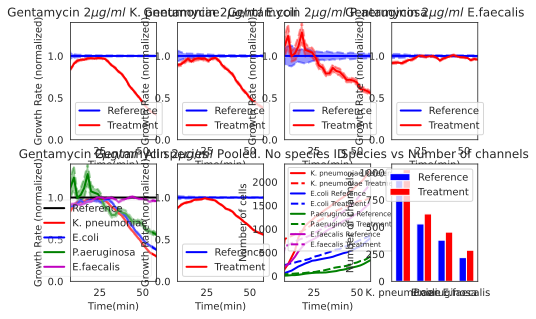

In [15]:
g.plot_all_figures()

In [16]:
color_scheme = {
    'Klebsiella': 'r', 'E.coli': 'b', 'E.cocci': 'c', 'Pseudomonas': 'g'
}

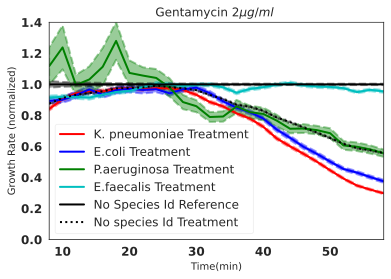

In [17]:
g.plot_species_wise_and_pooled(color_scheme=color_scheme)